# APPM 5720 Biweekly Report - Part 1
### *Alexey Yermakov*
### *October 13, 2022*

# Summary
In this section, I follow in the footsteps of my previous report where I loaded a pre-trained resnet model and retrained the last layer on the cats vs dogs dataset. Here, I load resnet18 in PyTorch since I found out I like it more than Tensorflow since it feels very similar to numpy and is more intuitive than Tensorflow. The code is not all my own, I took code from the various sources listed throughout. However, all comments and markdown blocks are my own.

# Main Content
First, I import various packages and verify my GPU is available.

In [1]:
# Make sure Torch is installed and our GPU is available
import torch
import numpy as np
from torch import nn, permute, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import urllib
from PIL import Image

!echo $CUDA_VISIBLE_DEVICES

print("GPU Available?",torch.cuda.is_available())
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"


GPU Available? True


Next, I define some constants that I'll be using when I load my dataset.

In [2]:
# Dataset Hyperparameters
batch_size = 32
shuffle = True

Now, I load my dataset. I have two parallel datasets: one that's preprocessed for printing nice figures, and another which is preprocessed to go into resnet18 for training. I had to have two models since they both have different transformations that are needed depending on their use.

Sources:
- [Dataset loading general](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
- [testing image on resnet](https://pytorch.org/hub/pytorch_vision_resnet/)

In [3]:
# Load datasets onto GPU

# Step 1: Load dataset
data_dir = '/home/alexey/Datasets/kaggle/cats_vs_dogs_parsed'

# Transform from image to tensor
transform_from_im = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# Required preprocessing for resnet trained on imagenet
transform_rn18 = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# resnet18 images
def f_rn18(im):
    tmp = transform_from_im(im)
    tmp = transform_rn18(tmp)
    return tmp

# Printing images
def f_printing(im):
    tmp = transform_from_im(im)
    tmp = permute(tmp, (1,2,0))
    return tmp

# From printing images to resnet18 images
def f_printing_to_rn18(im):
    tmp = permute(im, (2,0,1))
    tmp = transform_rn18(tmp)
    return tmp
    
# Load our dataset from disk, '_t' indicates preprocessed data for resnet18
train_data_t = datasets.ImageFolder(
    root=data_dir+'/train',
    transform=f_rn18
)

val_data_t = datasets.ImageFolder(
    root=data_dir+'/validation',
    transform=f_rn18
)

train_data = datasets.ImageFolder(
    root=data_dir+'/train',
    transform=f_printing
)

val_data = datasets.ImageFolder(
    root=data_dir+'/validation',
    transform=f_printing
)

# Step 2: Make a dataloader for easy shuffling and batching
#         '_t' indicates preprocessed data for resnet18
train_dl_t = DataLoader(train_data_t, batch_size=batch_size, shuffle=shuffle)
test_dl_t = DataLoader(val_data_t, batch_size=batch_size, shuffle=shuffle)

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
test_dl = DataLoader(val_data, batch_size=batch_size, shuffle=shuffle)

# Step 3: Make a wrapper so we push our data to GPU for each batch
def preprocess(x, y):
    return x.to(device), y.to(device)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            # *b makes it so that the input to func is two variables: the images and the labels
            # yield is like return except it stops execution until the object is "grabbed"
            yield (self.func(*b)) 

train_dl_t2 = WrappedDataLoader(train_dl_t, preprocess)
test_dl_t2 = WrappedDataLoader(test_dl_t, preprocess)

# Step 4: Verify our device is a GPU for each batch
batch = next(iter(train_dl_t))
print("Regular dataloader device: ", batch[0].device) # Should print something like "cpu"
batch = next(iter(train_dl_t2))
print("Modified dataloader device:", batch[0].device) # Should print something like "cuda:0" instead of "cpu"
print()

# Step 5: Print sizes of datasets
total_im = len(train_data) + len(val_data)
print("Training images:  ",len(train_data), f", {len(train_data)/total_im*100:02f}%")
print("Validation images:",len(val_data), f", {len(val_data)/total_im*100:02f}%")

Regular dataloader device:  cpu
Modified dataloader device: cuda:0

Training images:   7102 , 74.585171%
Validation images: 2420 , 25.414829%


For this next part, I print some samples from my dataset to see some examples.

Training data sample (not preprocessed for resnet):


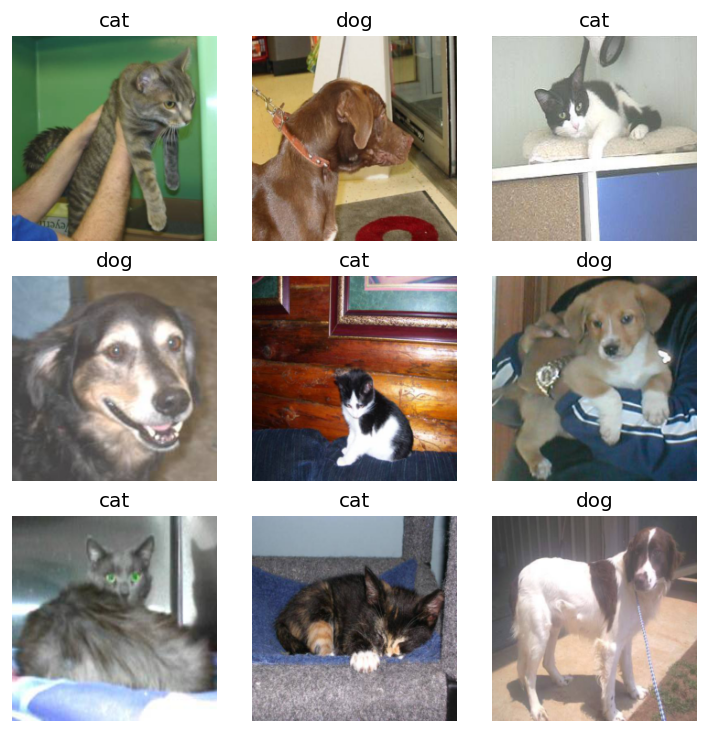

In [4]:
# Plot training data sample
print("Training data sample (not preprocessed for resnet):")

batch = next(iter(train_dl))

# Create our figure as a grid
ncols = 3
nrows = 3
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(6,6), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
        image = batch[0][nrows*r+c]
            
        label = "dog" if int(batch[1][nrows*r+c].item()) else "cat"
        
        ax = f1_axes[r][c]
        ax.set_axis_off()
        ax.set_title(label)
        ax.imshow(np.asarray(image))

plt.show()

This next part is similar to the previous code block, except these figures are what resnet18 is going to see.

Training data sample (preprocessed for resnet):


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


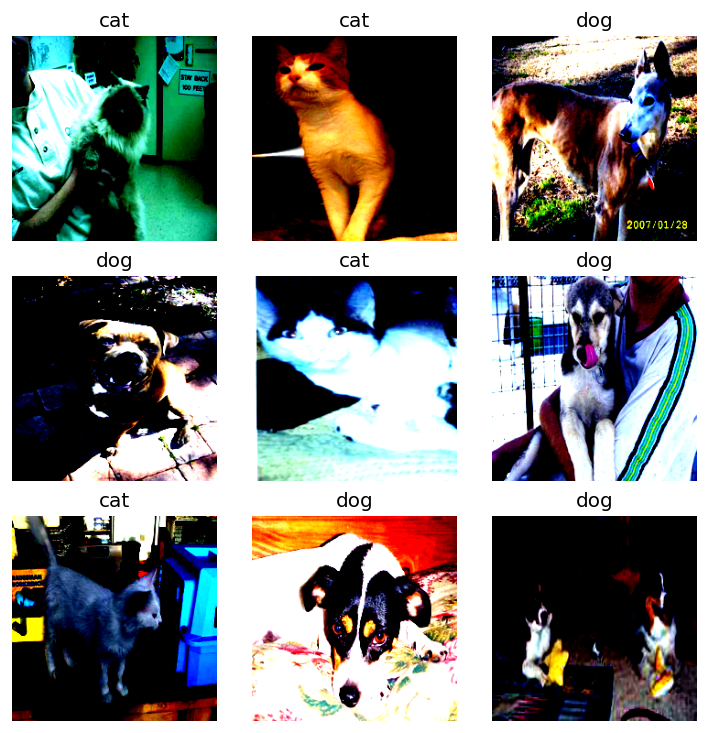

In [5]:
# Plot training data sample
print("Training data sample (preprocessed for resnet):")

batch = next(iter(train_dl_t))

# Create our figure as a grid
ncols = 3
nrows = 3
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(6,6), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
        image = batch[0][nrows*r+c]
        
        # Convert image dimensions from resnet
        image = permute(image, (1,2,0))
            
        label = "dog" if int(batch[1][nrows*r+c].item()) else "cat"
        
        ax = f1_axes[r][c]
        ax.set_axis_off()
        ax.set_title(label)
        ax.imshow(np.asarray(image))

plt.show()

Now I can load resnet18 and verify it's working correctly.

Sources:
- [transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [loading resnet18](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18)
- [resnet18 layers](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)
- [testing image on resnet](https://pytorch.org/hub/pytorch_vision_resnet/)

In [6]:
# Load resnet18 with weights
rn18 = models.resnet18(weights = models.ResNet18_Weights.DEFAULT).to(device)
for param in rn18.parameters():
    param.requires_grad = False
print("Final resnet18 layer:",rn18.fc)

Final resnet18 layer: Linear(in_features=512, out_features=1000, bias=True)


Easy enough! Lets see if we can classify images from the imagenet model correctly. First I'll download a sample image.

Sample image:


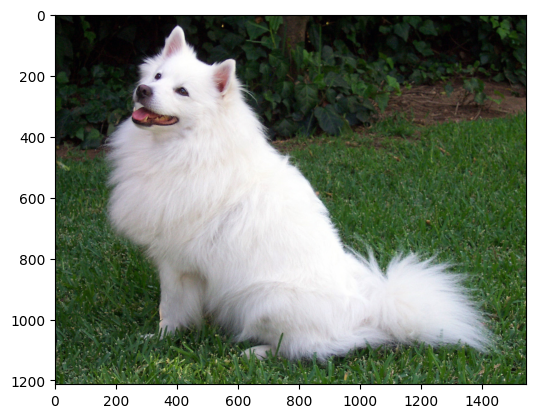

In [23]:
# Download sample image from the 'testing image on resnet' link above
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "Images/dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

# Show image
input_image = Image.open(filename)
print("Sample image:")
plt.imshow(input_image)

Next, I'll see what it gets classified as.

In [8]:
# Set rn18 to evaluation mode
rn18.eval()

# Convert image to something resnet expects
input_tensor = f_rn18(input_image)
input_batch = input_tensor.unsqueeze(0).to(device)

# Get imagenet labels as a list of strings
labels = open("/home/alexey/Datasets/labels.txt", "r")
labels.seek(0)
labels_list = labels.readlines()
labels.close()

# Get output
with torch.no_grad():
    output = rn18(input_batch)
index = torch.argmax(torch.nn.functional.softmax(output[0], dim=0))
print("Resnet18 imagenet label:", labels_list[index])

Resnet18 imagenet label: 258 Samoyed, Samoyede



Perfect! That's exactly what we'd expect. What happens if I run resnet18 on the cats vs dogs dataset?

Training data sample w/ resnet18 results:


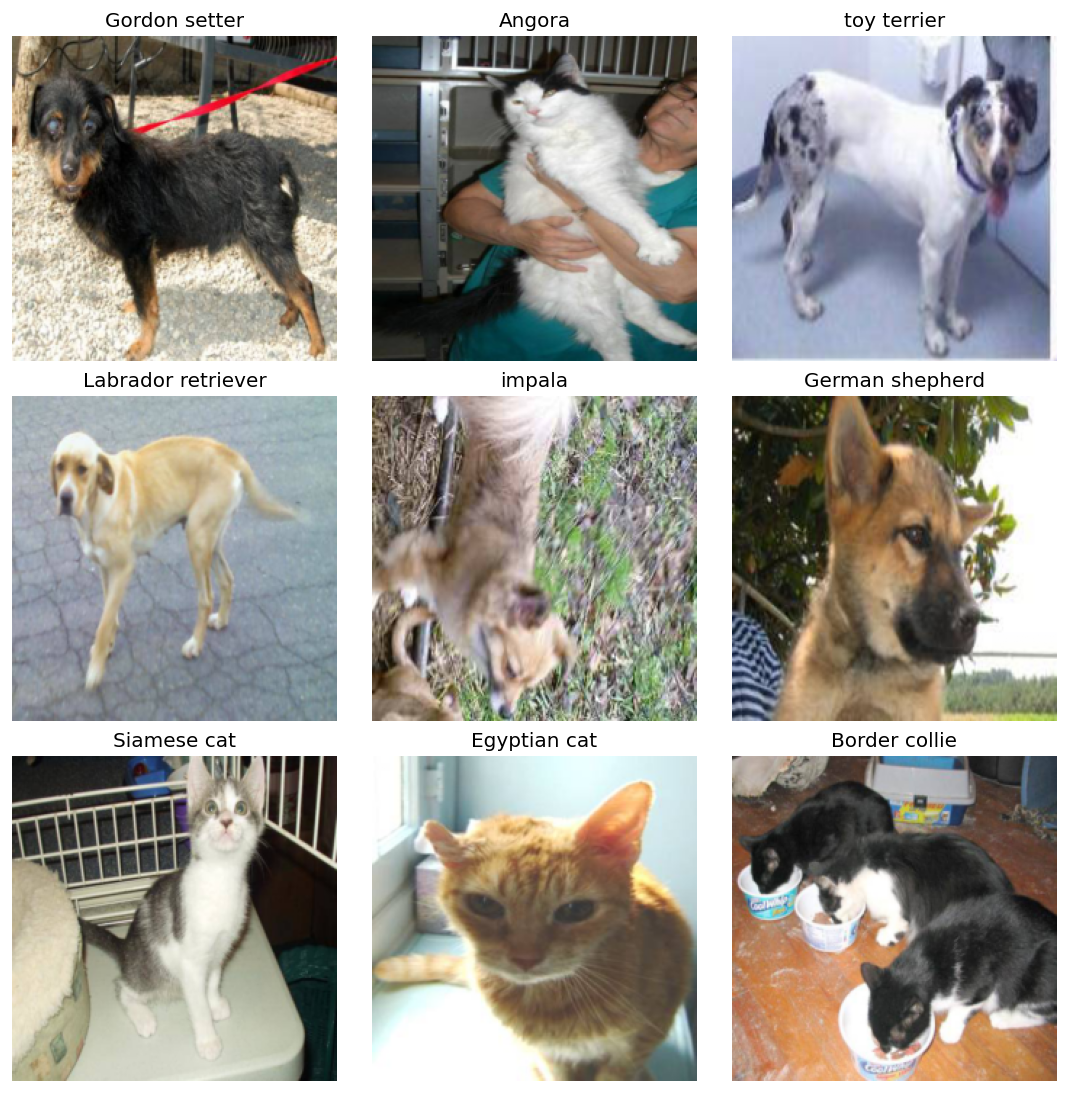

In [9]:
# Plot training data sample
print("Training data sample w/ resnet18 results:")
    
# Use CPU version of training data
batch = next(iter(train_dl))

# Create our figure as a grid
ncols = 3
nrows = 3
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(9,9), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
        image = batch[0][nrows*r+c]
        image_rn18 = f_printing_to_rn18(image)
        
        input_batch = image_rn18.unsqueeze(0).to(device)
        with torch.no_grad():
            output = rn18(input_batch)
        index = torch.argmax(torch.nn.functional.softmax(output[0], dim=0))
        label = labels_list[index]
        
        ax = f1_axes[r][c]
        ax.set_axis_off()
        ax.set_title(",".join(" ".join(label.split()[1:]).split(',')[0:1]))
        ax.imshow(np.asarray(image))

plt.show()

Close! The reason transfer learning works with resnet18 trained on imagenet is because there are features that are learned for adjacent labels. For example, the "cat" label we want to train can use features from "tabby" and "tiger cat". Similar labels exist for "dog". This transfer learning would be different if we transferred imagenet labels to something like identifying patterns in a blanket.

Lets now remove the last fully connected layer which has an output of 1,000 (for the number of labels in imagenet) to an output of 2 (for the two labels in cats vs dogs). I want to see how well we can classify our dataset with the randomly initialized weights of this final layer.

(Note that the next code block is to define how we'll train our model, but I only placed it here to use the `val_loop` function to get the accuracy of our model before training. I use the rest of the code later in this notebook)

In [10]:
# Define the training and validation loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)*batch_size
    print("Processing", len(dataloader), "batches of size", batch_size, "images")
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch % (len(dataloader)//10) == 0) or (batch == len(dataloader)):
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}, {current/size*100:>2.0f}%]")


def val_loop(dataloader, model, loss_fn):
    size = len(dataloader)*batch_size
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Define our loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.NAdam(rn18.parameters(), lr=0.01, betas = (0.9,0.999), eps=1e-07)

Training data sample w/ resnet18 retrained:


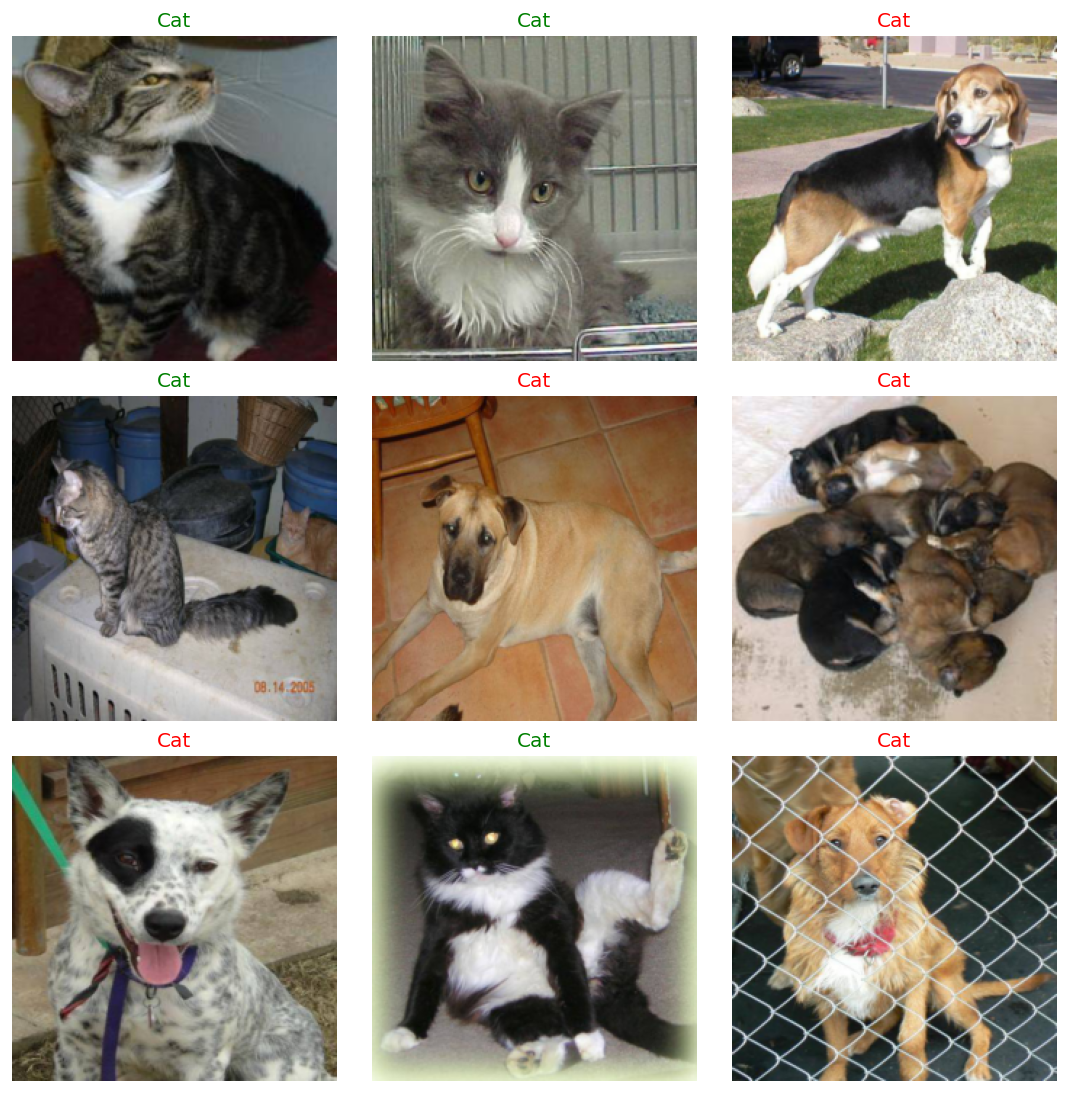

Test Error: 
 Accuracy: 36.1%, Avg loss: 0.886878 



In [11]:
# Set rn18 to evaluation mode and make it a 2-class classifier
in_ftrs = 512 # from `rn18.fc.in_features`
out_ftrs = 2
rn18.fc = nn.Linear(in_ftrs, out_ftrs)
rn18.to(device)
rn18.eval()

# Plot training data sample
print("Training data sample w/ resnet18 retrained:")
    
# Use CPU version of training data
batch = next(iter(train_dl))

# Create our figure as a grid
ncols = 3
nrows = 3
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(9,9), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
        image = batch[0][nrows*r+c]
        label = batch[1][nrows*r+c].item()
        image_rn18 = f_printing_to_rn18(image)
        
        input_batch = image_rn18.unsqueeze(0).to(device)
        with torch.no_grad():
            output = rn18(input_batch)
        guess = torch.argmax(torch.nn.functional.softmax(output[0], dim=0)).item()
        color = "green" if label == guess else "red"
        guess = "Dog" if guess else "Cat"
        
        ax = f1_axes[r][c]
        ax.set_axis_off()
        ax.set_title(guess,
                    fontdict = {'color': color})
        ax.imshow(np.asarray(image))

plt.show()

val_loop(test_dl_t2, rn18, loss_fn)

Not very good! But this is what we expect with randomly initialized weights. Lets now train our model on our dataset. First, lets make it trainable by freezing all layers except the last one we modified. Note that the above image classifies everything as a "cat", this is just random behavior, other times I ran it it would sometimes classify a cat as a dog as well.

In [12]:
# Set to trainable
rn18.train()

# Move to gpu with the new layer
rn18.to(device)

# Define our loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.NAdam(rn18.parameters(), lr=0.01, betas = (0.9,0.999), eps=1e-07)

# Enable fully connected layer to training, disable everything else
for param in rn18.parameters():
    param.requires_grad = False

for param in rn18.fc.parameters():
    param.requires_grad = True
    print(param.requires_grad)
print("Final resnet18 layer:",rn18.fc)

True
True
Final resnet18 layer: Linear(in_features=512, out_features=2, bias=True)


Now, lets train the model. I used cross entropy loss because of the structure of my model, where I have two nodes as output instead of one (binary cross entropy was throwing me errors). I used NAdam as my optimizer because that's what I used in my last report with Tensorflow.

In [13]:
# Run training and validation
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------------")
    train_loop(train_dl_t2, rn18, loss_fn, optimizer)
    val_loop(test_dl_t2, rn18, loss_fn)
print("Done!")

Epoch 1
---------------------------------
Processing 222 batches of size 32 images
loss: 0.723044  [    0/ 7104,  0%]
loss: 0.034487  [  704/ 7104, 10%]
loss: 0.025970  [ 1408/ 7104, 20%]
loss: 0.074456  [ 2112/ 7104, 30%]
loss: 0.015731  [ 2816/ 7104, 40%]
loss: 0.566967  [ 3520/ 7104, 50%]
loss: 0.174980  [ 4224/ 7104, 59%]
loss: 0.143509  [ 4928/ 7104, 69%]
loss: 0.580167  [ 5632/ 7104, 79%]
loss: 0.064186  [ 6336/ 7104, 89%]
loss: 0.089648  [ 7040/ 7104, 99%]
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.208002 

Epoch 2
---------------------------------
Processing 222 batches of size 32 images
loss: 0.257858  [    0/ 7104,  0%]
loss: 0.015442  [  704/ 7104, 10%]
loss: 0.057822  [ 1408/ 7104, 20%]
loss: 0.123511  [ 2112/ 7104, 30%]
loss: 0.044366  [ 2816/ 7104, 40%]
loss: 0.714369  [ 3520/ 7104, 50%]
loss: 0.041380  [ 4224/ 7104, 59%]
loss: 0.381372  [ 4928/ 7104, 69%]
loss: 0.078334  [ 5632/ 7104, 79%]
loss: 0.045389  [ 6336/ 7104, 89%]
loss: 0.000210  [ 7040/ 7104, 99%]
Test Error: 

Great! From our final accuracy it's clear that the transfer learning was a success. Lets see how we did visually.

Training data sample w/ resnet18 retrained:


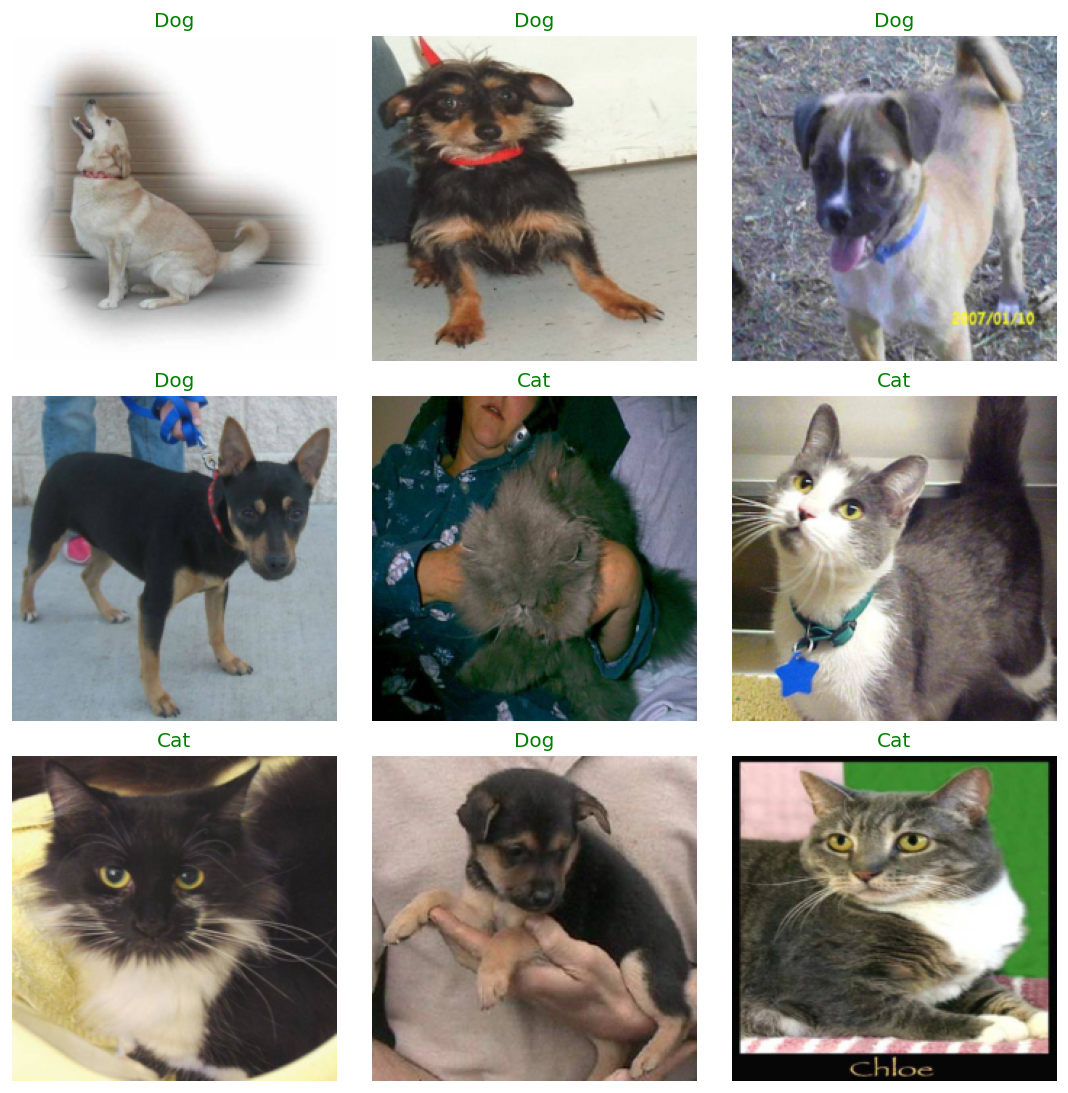

In [22]:
# Set rn18 to evaluation mode
rn18.eval()

# Plot training data sample
print("Training data sample w/ resnet18 retrained:")
    
# Use CPU version of training data
batch = next(iter(train_dl))

# Create our figure as a grid
ncols = 3
nrows = 3
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(9,9), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
        image = batch[0][nrows*r+c]
        label = batch[1][nrows*r+c]
        image_rn18 = f_printing_to_rn18(image)
        
        input_batch = image_rn18.unsqueeze(0).to(device)
        with torch.no_grad():
            output = rn18(input_batch)
        guess = torch.argmax(torch.nn.functional.softmax(output[0], dim=0)).item()
        color = "green" if label == guess else "red"
        guess = "Dog" if guess else "Cat"
        
        ax = f1_axes[r][c]
        ax.set_axis_off()
        ax.set_title(guess,
                    fontdict = {'color': color})
        ax.imshow(np.asarray(image))

plt.show()

Great! Now that I have some code I can use for transfer learning, lets explore how data augmentation affects the performance of our training. In the next section, I implement my own random erasing function which I optimized for runtime based on the algorithm presented in the original paper. Afterwards, I do the same transfer learning as in this notebook, but with a variety of data augmentation techniques.